In [47]:
# imports
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import transform_dataframe, plot_history, regression_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, Dropout, LSTM, Dense, TimeDistributed
from tensorflow.keras.ops import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, BackupAndRestore, EarlyStopping
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [48]:
# configurate general settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [4]:
# get the raw data directory
raw_data_dir = os.path.dirname(os.getcwd())

In [5]:
# load data
df_telemetry = pd.read_csv(os.path.join(raw_data_dir, "raw_data/PdM_telemetry.csv"))
df_errors = pd.read_csv(os.path.join(raw_data_dir, "raw_data/PdM_errors.csv"))
df_failures = pd.read_csv(os.path.join(raw_data_dir, "raw_data/PdM_failures.csv"))
df_machines = pd.read_csv(os.path.join(raw_data_dir, "raw_data/PdM_machines.csv"))
df_components = pd.read_csv(os.path.join(raw_data_dir, "raw_data/PdM_maint.csv"))

# Feature Engineering

In [6]:
# create an error count column for each datetime and machine id pair
df_components = df_components.groupby(by=["datetime", "machineID"], as_index=False).count()
df_components.rename(columns={"comp": "comp_count"}, inplace=True)
df_components


,datetime,machineID,comp_count
0,2014-06-01 06:00:00,1,1
1,2014-06-01 06:00:00,6,1
2,2014-06-01 06:00:00,9,2
3,2014-06-01 06:00:00,11,1
4,2014-06-01 06:00:00,16,1
...,...,...,...
2523,2016-01-01 06:00:00,35,1
2524,2016-01-01 06:00:00,42,1
2525,2016-01-01 06:00:00,43,1
2526,2016-01-01 06:00:00,55,1


In [7]:
# create an error count column for each datetime and machine id pair
df_errors = df_errors.groupby(by=["datetime", "machineID"], as_index=False).count()
df_errors.rename(columns={"errorID": "error_count"}, inplace=True)
df_errors

,datetime,machineID,error_count
0,2015-01-01 06:00:00,24,1
1,2015-01-01 06:00:00,73,1
2,2015-01-01 06:00:00,81,1
3,2015-01-01 07:00:00,43,1
4,2015-01-01 08:00:00,14,1
...,...,...,...
3611,2015-12-31 18:00:00,91,1
3612,2015-12-31 20:00:00,23,1
3613,2015-12-31 23:00:00,94,1
3614,2016-01-01 05:00:00,8,1


In [8]:
# create an failures comonent count column for each datetime and machine id pair
df_failures = df_failures.groupby(by=["datetime", "machineID"], as_index=False).count()
df_failures.rename(columns={"failure": "failure_component_count"}, inplace=True)
df_failures

,datetime,machineID,failure_component_count
0,2015-01-02 03:00:00,16,2
1,2015-01-02 03:00:00,17,1
2,2015-01-02 03:00:00,22,1
3,2015-01-02 03:00:00,35,1
4,2015-01-02 03:00:00,45,1
...,...,...,...
714,2015-12-30 06:00:00,88,1
715,2015-12-31 06:00:00,15,1
716,2015-12-31 06:00:00,64,1
717,2015-12-31 06:00:00,90,1


In [9]:
# join dataframes
df_maintenance = df_telemetry.merge(df_machines, on="machineID", how="left").merge(df_components, on=["datetime", "machineID"], how="left").merge(df_errors, on=["datetime", "machineID"], how="left").merge(df_failures, on=["datetime", "machineID"], how="left")
df_maintenance

,datetime,machineID,volt,rotate,pressure,vibration,model,age,comp_count,error_count,failure_component_count
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5,NaN,NaN,NaN
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5,NaN,NaN,NaN
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5,NaN,NaN,NaN
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5,NaN,NaN,NaN


In [10]:
# replace nan values by 0
df_maintenance.fillna(0, inplace=True)

In [11]:
# change the age column type to float
df_maintenance["age"] = df_maintenance["age"].astype(float)

In [12]:
df_maintenance["datetime"] = pd.to_datetime(df_maintenance["datetime"]) # change datetime column type to datetime
df_maintenance.set_index("datetime", inplace=True) # set datetime column as index

In [13]:
df_transformed = transform_dataframe(df_maintenance) # transform dataframe
df_transformed.reset_index(inplace=True, drop=True) # reset index
df_transformed

,volt(t-30),rotate(t-30),pressure(t-30),vibration(t-30),comp_count(t-30),error_count(t-30),failure_component_count(t-30),volt(t-29),rotate(t-29),pressure(t-29),vibration(t-29),comp_count(t-29),error_count(t-29),failure_component_count(t-29),volt(t-28),rotate(t-28),pressure(t-28),vibration(t-28),comp_count(t-28),error_count(t-28),failure_component_count(t-28),volt(t-27),rotate(t-27),pressure(t-27),vibration(t-27),comp_count(t-27),error_count(t-27),failure_component_count(t-27),volt(t-26),rotate(t-26),pressure(t-26),vibration(t-26),comp_count(t-26),error_count(t-26),failure_component_count(t-26),volt(t-25),rotate(t-25),pressure(t-25),vibration(t-25),comp_count(t-25),error_count(t-25),failure_component_count(t-25),volt(t-24),rotate(t-24),pressure(t-24),vibration(t-24),comp_count(t-24),error_count(t-24),failure_component_count(t-24),volt(t-23),rotate(t-23),pressure(t-23),vibration(t-23),comp_count(t-23),error_count(t-23),failure_component_count(t-23),volt(t-22),rotate(t-22),pressure(t-22),vibration(t-22),comp_count(t-22),error_count(t-22),failure_component_count(t-22),volt(t-21),rotate(t-21),pressure(t-21),vibration(t-21),comp_count(t-21),error_count(t-21),failure_component_count(t-21),volt(t-20),rotate(t-20),pressure(t-20),vibration(t-20),comp_count(t-20),error_count(t-20),failure_component_count(t-20),volt(t-19),rotate(t-19),pressure(t-19),vibration(t-19),comp_count(t-19),error_count(t-19),failure_component_count(t-19),volt(t-18),rotate(t-18),pressure(t-18),vibration(t-18),comp_count(t-18),error_count(t-18),failure_component_count(t-18),volt(t-17),rotate(t-17),pressure(t-17),vibration(t-17),comp_count(t-17),error_count(t-17),failure_component_count(t-17),volt(t-16),rotate(t-16),pressure(t-16),vibration(t-16),comp_count(t-16),error_count(t-16),failure_component_count(t-16),volt(t-15),rotate(t-15),pressure(t-15),vibration(t-15),comp_count(t-15),error_count(t-15),failure_component_count(t-15),volt(t-14),rotate(t-14),pressure(t-14),vibration(t-14),comp_count(t-14),error_count(t-14),failure_component_count(t-14),volt(t-13),rotate(t-13),pressure(t-13),vibration(t-13),comp_count(t-13),error_count(t-13),failure_component_count(t-13),volt(t-12),rotate(t-12),pressure(t-12),vibration(t-12),comp_count(t-12),error_count(t-12),failure_component_count(t-12),volt(t-11),rotate(t-11),pressure(t-11),vibration(t-11),comp_count(t-11),error_count(t-11),failure_component_count(t-11),volt(t-10),rotate(t-10),pressure(t-10),vibration(t-10),comp_count(t-10),error_count(t-10),failure_component_count(t-10),volt(t-9),rotate(t-9),pressure(t-9),vibration(t-9),comp_count(t-9),error_count(t-9),failure_component_count(t-9),volt(t-8),rotate(t-8),pressure(t-8),vibration(t-8),comp_count(t-8),error_count(t-8),failure_component_count(t-8),volt(t-7),rotate(t-7),pressure(t-7),vibration(t-7),comp_count(t-7),error_count(t-7),failure_component_count(t-7),volt(t-6),rotate(t-6),pressure(t-6),vibration(t-6),comp_count(t-6),error_count(t-6),failure_component_count(t-6),volt(t-5),rotate(t-5),pressure(t-5),vibration(t-5),comp_count(t-5),error_count(t-5),failure_component_count(t-5),volt(t-4),rotate(t-4),pressure(t-4),vibration(t-4),comp_count(t-4),error_count(t-4),failure_component_count(t-4),volt(t-3),rotate(t-3),pressure(t-3),vibration(t-3),comp_count(t-3),error_count(t-3),failure_component_count(t-3),volt(t-2),rotate(t-2),pressure(t-2),vibration(t-2),comp_count(t-2),error_count(t-2),failure_component_count(t-2),volt(t-1),rotate(t-1),pressure(t-1),vibration(t-1),comp_count(t-1),error_count(t-1),failure_component_count(t-1),model,age,RUL
0,167.576533,440.515328,98.522345,40.049623,0.0,0.0,0.0,169.795758,446.832666,98.454608,39.271645,0.0,0.0,0.0,171.862244,459.204742,97.998233,48.074091,0.0,2.0,0.0,174.792428,448.743201,101.452266,52.190268,0.0,1.0,0.0,171.018408,454.822750,102.363114,43.330311,2.0,0.0,1.0,171.025033,454.614348,102.377665,41.506930,0.0,0.0,0.0,174.139410,444.337772,96.674842,41.702771,0.0,0.0,0.0,172.135931,446.126781,102.097039,39.281983,0.0,0.0,0.0,169.350052

Text(0, 0.5, 'Count')

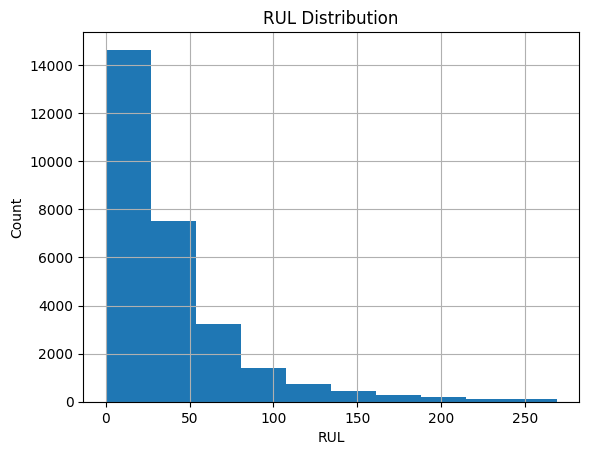

In [16]:
# display the RUL distribution
df_transformed.RUL.hist()
plt.title("RUL Distribution")
plt.xlabel("RUL")
plt.ylabel("Count")

# Data Preprocessing

In [17]:
# defining features and target
X = df_transformed.drop(columns="RUL")
y = df_transformed["RUL"]

In [18]:
# splitting dataset into training, validation and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
# define numerical columns
num_cols = df_transformed.select_dtypes(float).columns
# define categorical columns
cat_cols = df_transformed.select_dtypes(object).columns
# create a column transformer for features
cols_transformer = ColumnTransformer((("num_transformer", StandardScaler(), num_cols),
                                    ("cat_transformer", OneHotEncoder(sparse_output=False), cat_cols)))

In [20]:
X_train_transformed = cols_transformer.fit_transform(X_train)
X_validation_transformed = cols_transformer.transform(X_validation)
X_test_transformed = cols_transformer.transform(X_test)

# Modeling & Evaluation

In [21]:
# define a beseline model
baseline_model = DummyRegressor(strategy='mean')

In [22]:
# fit the baseline regressor
baseline_model.fit(X_train_transformed, y_train)
# baseline model metrics
print(regression_metrics(baseline_model, X_train_transformed, X_test_transformed, y_train, y_test))

Metric    Training Set    Test Set
--------  --------------  -----------
r2        0               -5.2454e-05
MSE       1604.4          1607.51
MAE       28.0813         28.4118
RMSE      40.055          40.0937


In [23]:
# define two sets of inputs representing time steps and non time steps features
# train inputs
time_steps_train_input = X_train_transformed[:, :-5].reshape((-1,30,7))
non_time_steps_train_input = X_train_transformed[:, -5:]

# validation inputs
time_steps_validation_input = X_validation_transformed[:, :-5].reshape((-1,30,7))
non_time_steps_validation_input = X_validation_transformed[:, -5:]

# test inputs
time_steps_test_input = X_test_transformed[:, :-5].reshape((-1,30,7))
non_time_steps_test_input = X_test_transformed[:, -5:]

In [30]:
# define time steps and non time steps inputs
time_steps_inputs = Input(shape=(30,7))
non_time_steps_inputs = Input(shape=(5,))

# define the lstm layers for the time steps inputs
x = LSTM(64, activation="relu", return_sequences=True)(time_steps_inputs)
x = LSTM(64, activation="relu", return_sequences=True)(x)
x = LSTM(16, activation="relu")(x)
x = Model(inputs=time_steps_inputs, outputs=x)

# combine the outputs of the lstm layers outputs and the other inputs
combined = concatenate([x.output, non_time_steps_inputs], axis=1)

# define dense layers
y = Dense(64, activation="relu")(combined)
y = Dense(64, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Dense(1, activation="relu")(y)

# define the model
nn_model = Model(inputs=[x.input, non_time_steps_inputs], outputs=y)

In [31]:
# define callbacks for the baseline model
backup_dir_path = "C:/Users/acer/Projects/predictive_maintenance/artifacts/callbacks/backup"
nn_model_checkpoint_path = "C:/Users/acer/Projects/predictive_maintenance/artifacts/callbacks/nn_model_checkpoint.keras"
model_checkpoint = ModelCheckpoint(
    filepath=nn_model_checkpoint_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True)
backup = BackupAndRestore(backup_dir=backup_dir_path)
model_callbacks=[backup, model_checkpoint]

In [32]:
# compile model
nn_model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.0005),
              metrics=["mae"])

In [33]:
# train model
model_history = nn_model.fit(x=[time_steps_train_input, non_time_steps_train_input],
        y=y_train,                         
        batch_size=32,
        epochs=700,
        validation_data=([time_steps_validation_input, non_time_steps_validation_input], y_validation),
        validation_batch_size=32,
        callbacks=model_callbacks)

Epoch 1/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 4625.4370 - mae: 33.4535 - val_loss: 1799.6689 - val_mae: 28.0487
Epoch 2/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 1609.8478 - mae: 27.1430 - val_loss: 1648.5803 - val_mae: 28.0131
Epoch 3/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - loss: 1536.8906 - mae: 27.0283 - val_loss: 1642.5142 - val_mae: 27.1200
Epoch 4/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - loss: 1459.9189 - mae: 26.2928 - val_loss: 1590.0699 - val_mae: 27.7103
Epoch 5/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - loss: 1466.1332 - mae: 26.9039 - val_loss: 1582.3871 - val_mae: 27.1829
Epoch 6/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 1418.4294 - mae: 26.3206 - val_loss: 1577.9115 - val_mae: 26.9796
Epoch 7/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - loss: 1440.2732 - mae: 26.5309 - val_loss: 1564.2932 - val_mae: 27.9156
Epoch 8/700
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - loss: 1403.3727 - mae: 26.4027 - val_los

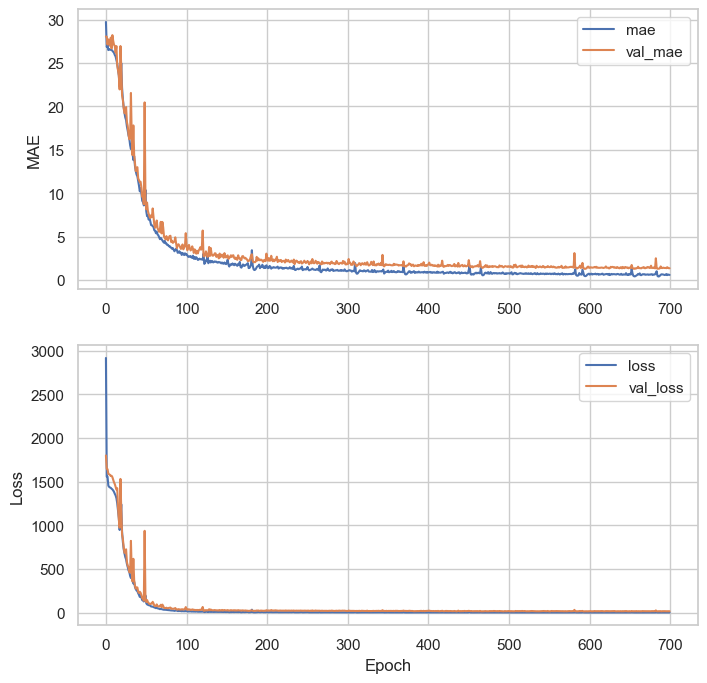

In [54]:
plot_history(model_history, "mae", "val_mae")

In [34]:
# load the trained model
trained_model = load_model(nn_model_checkpoint_path)

In [35]:
print(regression_metrics(trained_model, [time_steps_train_input, non_time_steps_train_input],
                         [time_steps_test_input, non_time_steps_test_input],
                         y_train, y_test))

627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.99934         0.98995
MSE       1.05967         16.1541
MAE       0.738144        1.51111
RMSE      1.0294          4.01922


The R2 score shows that the model is explaining about 99% of the variance in the target which is a good result. Depending on the mean absolute error score, the model tends to make an error of about 2 days, and since the root mean squared error is significantly higher than the mean absolute error, this shows us that it has made some larger errors on some samples.